In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 죽동2동 데이터 추출

In [2]:
data = pd.read_csv('./211104/211105 jukdong2.csv', parse_dates = True)

In [3]:
data

,Cons_jukdong2(W)
0,862.0
1,836.5
2,756.5
3,143.4
4,224.2
...,...
6547,731.5
6548,614.9
6549,1114.7
6550,954.4


In [4]:
# 2월1일 00시부터 10월 31일 23까지의 데이터 생성
df_jukdong2 = pd.DataFrame(pd.date_range('2021-02-01 00:00:00', '2021-10-31 23:00:00', freq='H'), columns=['Time'])

In [5]:
df_jukdong2['Cons_jukdong2(W)'] = data['Cons_jukdong2(W)']

In [6]:
df_jukdong2

,Time,Cons_jukdong2(W)
0,2021-02-01 00:00:00,862.0
1,2021-02-01 01:00:00,836.5
2,2021-02-01 02:00:00,756.5
3,2021-02-01 03:00:00,143.4
4,2021-02-01 04:00:00,224.2
...,...,...
6547,2021-10-31 19:00:00,731.5
6548,2021-10-31 20:00:00,614.9
6549,2021-10-31 21:00:00,1114.7
6550,2021-10-31 22:00:00,954.4


In [7]:
df_jukdong2=df_jukdong2.set_index('Time')

In [8]:
df_jukdong2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6552 entries, 2021-02-01 00:00:00 to 2021-10-31 23:00:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cons_jukdong2(W)  6552 non-null   float64
dtypes: float64(1)
memory usage: 102.4 KB


In [9]:
df_jukdong2

,Cons_jukdong2(W)
Time,
2021-02-01 00:00:00,862.0
2021-02-01 01:00:00,836.5
2021-02-01 02:00:00,756.5
2021-02-01 03:00:00,143.4
2021-02-01 04:00:00,224.2
...,...
2021-10-31 19:00:00,731.5
2021-10-31 20:00:00,614.9
2021-10-31 21:00:00,1114.7


# KePSH1 PV 데이터 추출 (디오텍)

In [10]:
df_DT = pd.read_csv('./211104_kepsh1_PV_DT.csv', parse_dates = True)

In [11]:
df_DT.drop(['Unnamed: 0'], inplace = True, axis =1 )

In [12]:
df_DT['Time']= pd.to_datetime(df_DT['Time'])

In [13]:
# 2월1 일 데이터부터 시작
df_DT=df_DT[(df_DT['Time']>='2021-02-01 00:00:00')]

In [14]:
df_DT=df_DT.set_index('Time')

In [15]:
# 1시간 평균
df_DT=df_DT.resample('1H').mean()

In [16]:
df_DT

,PV_kepsh1_DT(W)
Time,
2021-02-01 00:00:00,0.0
2021-02-01 01:00:00,0.0
2021-02-01 02:00:00,0.0
2021-02-01 03:00:00,0.0
2021-02-01 04:00:00,0.0
...,...
2021-10-31 19:00:00,0.0
2021-10-31 20:00:00,0.0
2021-10-31 21:00:00,0.0


# 죽동소비량과 KePSH1 PV생산량 Concat

In [17]:
df_merge=pd.merge(df_jukdong2, df_DT, how='outer', on='Time')

In [18]:
df_merge

,Cons_jukdong2(W),PV_kepsh1_DT(W)
Time,,
2021-02-01 00:00:00,862.0,0.0
2021-02-01 01:00:00,836.5,0.0
2021-02-01 02:00:00,756.5,0.0
2021-02-01 03:00:00,143.4,0.0
2021-02-01 04:00:00,224.2,0.0
...,...,...
2021-10-31 19:00:00,731.5,0.0
2021-10-31 20:00:00,614.9,0.0
2021-10-31 21:00:00,1114.7,0.0


In [19]:
# 총 6552 EA data 중 PV데이터는 6380 EA 존재 (172EA 데이터 결측치)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6552 entries, 2021-02-01 00:00:00 to 2021-10-31 23:00:00
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cons_jukdong2(W)  6552 non-null   float64
 1   PV_kepsh1_DT(W)   6380 non-null   float64
dtypes: float64(2)
memory usage: 153.6 KB


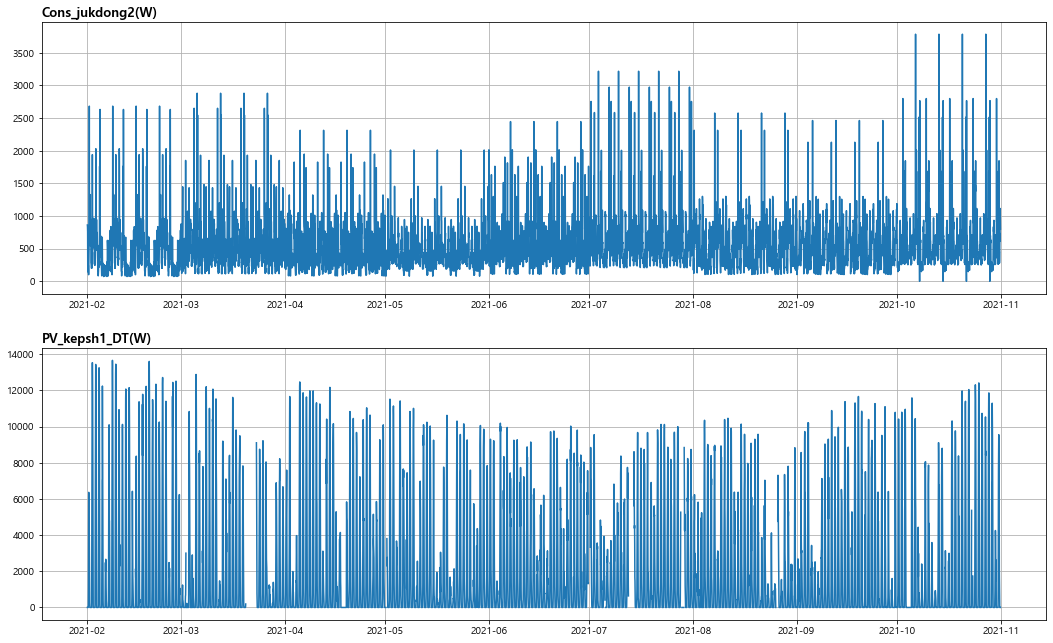

In [20]:
fig, ax = plt.subplots(figsize=(18,11))

for i in range(len(df_merge.columns)):
    plt.subplot(len(df_merge.columns), 1, i+1)
    name = df_merge.columns[i]
    plt.plot(df_merge[name])    
    plt.title(name, loc = 'left', pad=5, fontsize=13, fontweight="bold")      
#     plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-08-31'))
    plt.yticks()
    plt.grid(True)
plt.show()
fig.tight_layout()

# 데이터계산

In [21]:
df_merge['ToGrid(W)'] = np.where((df_merge['PV_kepsh1_DT(W)']-df_merge['Cons_jukdong2(W)'])<0, 0, df_merge['PV_kepsh1_DT(W)']-df_merge['Cons_jukdong2(W)'])                               

In [22]:
df_merge['ToGrid_acc(W)'] = df_merge['ToGrid(W)'].cumsum()*60*24/3600
df_merge['Cons_acc_jukdong2(Wh)'] = df_merge['Cons_jukdong2(W)'].cumsum()*60*24/3600
df_merge['Prod_acc_kepsh1(Wh)'] = df_merge['PV_kepsh1_DT(W)'].cumsum()*60*24/3600

In [23]:
df_merge['denominator'] = df_merge.loc[:,['Cons_jukdong2(W)','PV_kepsh1_DT(W)']].min(axis=1)
df_merge['denominator_acc'] = df_merge.loc[:,['Cons_acc_jukdong2(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [24]:
df_merge['SCF'] = df_merge['denominator']/df_merge['PV_kepsh1_DT(W)']
df_merge['LCF'] = df_merge['denominator']/df_merge['Cons_jukdong2(W)']
df_merge['SCF_acc'] = df_merge['denominator_acc']/df_merge['Prod_acc_kepsh1(Wh)']
df_merge['LCF_acc'] = df_merge['denominator_acc']/df_merge['Cons_acc_jukdong2(Wh)']
df_merge['self_sustain'] = df_merge['Prod_acc_kepsh1(Wh)']/df_merge['Cons_acc_jukdong2(Wh)']
df_merge['Avg_SCF&LCF'] = (df_merge['SCF_acc']+df_merge['LCF_acc'])/2

In [25]:
df_merge

,Cons_jukdong2(W),PV_kepsh1_DT(W),ToGrid(W),ToGrid_acc(W),Cons_acc_jukdong2(Wh),Prod_acc_kepsh1(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,
2021-02-01 00:00:00,862.0,0.0,0.0,0.000000e+00,344.80,0.000000e+00,0.0,0.00,NaN,0.0,NaN,0.0,0.000000,NaN
2021-02-01 01:00:00,836.5,0.0,0.0,0.000000e+00,679.40,0.000000e+00,0.0,0.00,NaN,0.0,NaN,0.0,0.000000,NaN
2021-02-01 02:00:00,756.5,0.0,0.0,0.000000e+00,982.00,0.000000e+00,0.0,0.00,NaN,0.0,NaN,0.0,0.000000,NaN
2021-02-01 03:00:00,143.4,0.0,0.0,0.000000e+00,1039.36,0.000000e+00,0.0,0.00,NaN,0.0,NaN,0.0,0.000000,NaN
2021-02-01 04:00:00,224.2,0.0,0.0,0.000000e+00,1129.04,0.000000e+00,0.0,0.00,NaN,0.0,NaN,0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 19:00:00,731.5,0.0,0.0,4.590438e+06,1379394.24,5.155653e+06,0.0,1379394.24,NaN,0.0,0.267550,1.0,3.737621,0.633775
2021-10-31 20:00:00,614.9,0.0,0.0,4.590438e+06,1379640.20,5.155653e+06,0.0,1379640.20,NaN,0.0,0.267598,1.0,3.736955,0.633799
2021-10-31 21:00:00,1114.7,0.0,0.0,4.590438e+06,1380086.08,5.155653e+06,0.0,1380086.08,NaN,0.0,0.267684,1.0,3.735747,0.633842


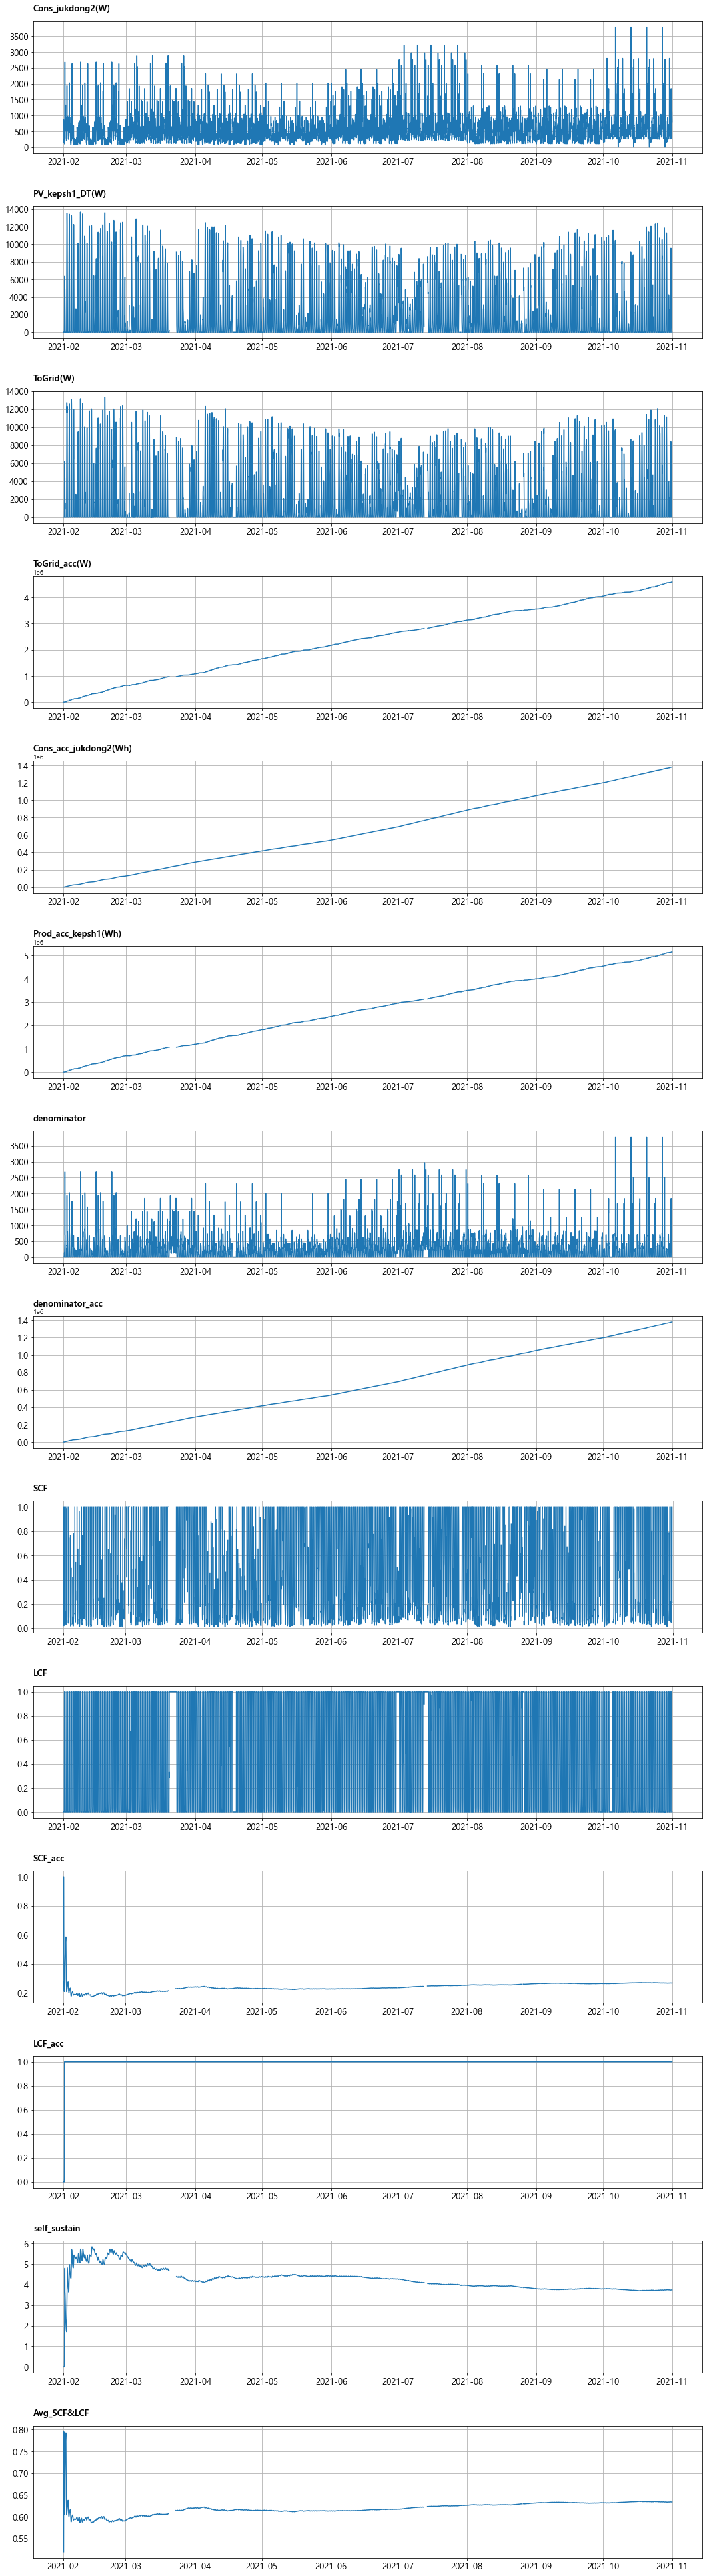

In [30]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_merge.columns)):
    plt.subplot(len(df_merge.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_merge.columns[i]
    plt.plot(df_merge[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [29]:
df_merge.to_csv('./211105_kepsh1_jukdong2.csv')

# Scatter plotting

In [ ]:
df_merge=pd.read_csv('./211105_kepsh1_jukdong2.csv', encoding='euc-kr', parse_dates=True)
df_merge['Time']=pd.to_datetime(df_merge['Time'])

In [ ]:
df_merge.info()

In [ ]:
fig, ax = plt.subplots(figsize=(18,60))


for i in range(len(df_merge.columns)):
    plt.subplot(len(df_merge.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_merge.columns[i]
    plt.scatter(x=df_merge['Time'], y=df_merge[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()